In [2]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
    Union
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.prebuilt import ToolNode
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_ollama import ChatOllama
from langchain_core.messages import ToolMessage,SystemMessage
from langchain_core.runnables import RunnableConfig
import json


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]
    generated_exps: dict
    exp_title:str
    reward:Union[int,float]


wrapper = DuckDuckGoSearchAPIWrapper(max_results=3)
search = DuckDuckGoSearchResults(api_wrapper=wrapper, output_format='list')

tools = [search]

model = ChatOllama(model="qwq",base_url="192.168.23.138:11439")
toolmodel = model.bind_tools(tools)

In [3]:
class ReAct_Format_thought(TypedDict):
    prompt:str 
    history:list
    current_query:str
    next_thought: str
    agent_scratchpad:str
    finish:bool
    final_response:str

class ReAct_Format_Action(TypedDict):
    prompt:str
    history:list
    next_query:str
    next_action:str
    agent_scratchpad:str

In [4]:
class State(TypedDict):
    thought_format : ReAct_Format_thought
    action_format: ReAct_Format_Action
    Final_output: str

def callThoughtNode():
    thought_system_prompt = '''You are a Lab Assistant designed to assist in conducting and reasoning about scientific experiments. Your task is to fill in only the next_thought field based on the chain of thought provided in the history and the latest current_query.

Input Format:
You will receive a JSON object structured as follows:

json
Copy
Edit
{
  "question": "user's current question",
  "history": [
    {
      "thought": "first thought from LLM",
      "action": "action performed based on thought",
      "observation": "observation obtained from action"
    },
    {
      "thought": "second thought from LLM",
      "action": "action performed based on second thought",
      "observation": "observation obtained from action"
    },
    ...
    {
      "action": "latest action performed",
      "observation": "latest observation obtained from action"
    }
  ],
  "current_query": "latest observation from experiment",
  "next_thought": "",
  "finish": "whether information is sufficient"
}
Your Task:
Your only task is to generate the next_thought based on:
The chain of thought in the history (i.e., previous thoughts, actions, and observations).
The current_query, which provides the most recent experimental observation.
DO NOT modify any other fields in the JSON. Simply populate the next_thought field.
Reasoning Logic:
If the information is insufficient:

Generate a next_thought that either:
Requests more information from the user, or
Suggests an external tool (like DuckDuckSearch) to gather more information.
Provide a brief justification for why the information is insufficient.
Example:
json
Copy
Edit
{
  "next_thought": "based on the observation i cannot determine what no of resistor is required. I would recommend searching for 'resistor required for ohms law verfication' to verify the behavior."
}
If the information is sufficient:

Generate a conclusive next thought directing the user to the next logical step in the experiment.
Provide clear reasoning based on the chain of thought.
Example:
json
Copy
Edit
{
  "next_thought": "i have sufficient information to make a complete experiment"
}
✅ Important Constraints:
⚠ DO NOT modify the question, history, current_query, or finish fields.
⚠ DO NOT generate any action or observation. Only generate the next thought.
⚠ Always think sequentially based on the chain of thought in the history.
⚠ If you believe the experiment has reached a conclusion, indicate it in next_thought, but do not touch the finish field.



    '''
    current_COT = '''
    "question": "what should be the required materials and experiment procedure of the following lab Experiment (To study the magnetic field produced by a solenoid and verify the relationship between current and magnetic field strength.)",
  "history": [  ],
  "current_query": "",
  "next_thought": "",
  "finish": ""

    '''
    return model.invoke(f"{thought_system_prompt}{current_COT}")

In [16]:
callThoughtNode()

AIMessage(content='<think>\n\nOkay, so the user is asking about the materials needed and the procedure for an experiment to study the magnetic field of a solenoid and verify how current affects the magnetic field strength. Let me start by breaking this down.\n\nFirst, I need to recall what a solenoid\'s magnetic field depends on. From what I remember, the magnetic field inside a solenoid is given by B = μ₀*(N/L)*I, where μ₀ is the permeability of free space, N is the number of turns, L is the length of the solenoid, and I is the current. So to verify the relationship between current (I) and magnetic field strength (B), they need to vary the current and measure B each time.\n\nNow, materials required: A solenoid itself would be essential. They probably need a power supply to control the current. To measure the current, an ammeter or multimeter would work. For measuring the magnetic field, maybe a Gauss meter or a Hall effect sensor? Also, a rheostat or variable resistor could help adjus

In [5]:
response_of_thought = '''"next_thought": "The experiment requires a solenoid, DC power supply, ammeter/multimeter, Gauss meter or Hall effect probe, rheostat, wires, and stands. Procedure: (1) Set up the solenoid with the magnetic sensor centered inside. (2) Connect to power supply via rheostat for variable current. (3) Measure B at increasing currents while recording I each time. (4) Plot B vs I to verify proportionality. This setup allows verification of B ∝ I as per theory."'''

In [6]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
    Union
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.prebuilt import ToolNode
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_ollama import ChatOllama
from langchain_core.messages import ToolMessage,SystemMessage
from langchain_core.runnables import RunnableConfig
import json


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]
    generated_exps: dict
    exp_title:str
    reward:Union[int,float]


wrapper = DuckDuckGoSearchAPIWrapper(max_results=3)
search = DuckDuckGoSearchResults(api_wrapper=wrapper, output_format='list')

tools = [search]

model = ChatOllama(model="jacob-ebey/phi4-tools:latest",base_url="192.168.23.138:11439")
model = model.bind_tools(tools)

In [7]:
system_message = '''
You will be provided with a thought segment of a prompt. Based on this thought, your task is to make appropriate tool calls to gather the necessary information from the available tools. The objective is to ensure that the thought is sufficiently satisfied by obtaining complete and relevant information from the tools.end if the messages are same just end the tool call and output that whatever you got and conlclude that i wasnt able to get more info
'''

In [8]:
import requests
import json
import time
import sys
import base64
import os
from typing import Dict, Any
from pydantic import BaseModel,Field
from typing import Union


class Crawl4AiTester:
    def __init__(self, base_url: str = "http://192.168.23.138:11235", api_token: str = None):
        self.base_url = base_url
        self.api_token = (
            api_token or os.getenv("CRAWL4AI_API_TOKEN") or "test_api_code"
        )  # Check environment variable as fallback
        self.headers = (
            {"Authorization": f"Bearer {self.api_token}"} if self.api_token else {}
        )

    def submit_and_wait(
        self, request_data: Dict[str, Any], timeout: int = 300
    ) -> Dict[str, Any]:
        # Submit crawl job
        response = requests.post(
            f"{self.base_url}/crawl", json=request_data, headers=self.headers
        )
        if response.status_code == 403:
            raise Exception("API token is invalid or missing")
        task_id = response.json()["task_id"]
        print(f"Task ID: {task_id}")

        # Poll for result
        start_time = time.time()
        while True:
            if time.time() - start_time > timeout:
                raise TimeoutError(
                    f"Task {task_id} did not complete within {timeout} seconds"
                )

            result = requests.get(
                f"{self.base_url}/task/{task_id}", headers=self.headers
            )
            status = result.json()

            if status["status"] == "failed":
                print("Task failed:", status.get("error"))
                raise Exception(f"Task failed: {status.get('error')}")

            if status["status"] == "completed":
                return status

            time.sleep(2)

    def submit_sync(self, request_data: Dict[str, Any]) -> Dict[str, Any]:
        response = requests.post(
            f"{self.base_url}/crawl_sync",
            json=request_data,
            headers=self.headers,
            timeout=60,
        )
        if response.status_code == 408:
            raise TimeoutError("Task did not complete within server timeout")
        response.raise_for_status()
        return response.json()

    def crawl_direct(self, request_data: Dict[str, Any]) -> Dict[str, Any]:
        """Directly crawl without using task queue"""
        response = requests.post(
            f"{self.base_url}/crawl_direct", json=request_data, headers=self.headers
        )
        response.raise_for_status()
        return response.json()


def test_docker_deployment(version="basic"):
    tester = Crawl4AiTester(
        base_url="http://192.168.23.138:11235",
        # base_url="https://api.crawl4ai.com" # just for example
        # api_token="test" # just for example
    )
    print(f"Testing Crawl4AI Docker {version} version")

    # Health check with timeout and retry
    max_retries = 5
    for i in range(max_retries):
        try:
            health = requests.get(f"{tester.base_url}/health", timeout=10)
            print("Health check:", health.json())
            break
        except requests.exceptions.RequestException:
            if i == max_retries - 1:
                print(f"Failed to connect after {max_retries} attempts")
                sys.exit(1)
            print(f"Waiting for service to start (attempt {i+1}/{max_retries})...")
            time.sleep(5)

    # Test cases based on version
    # test_basic_crawl_direct(tester)
    # test_basic_crawl(tester)
    # test_basic_crawl(tester)
    # test_basic_crawl_sync(tester)

    # if version in ["full", "transformer"]:
    #     test_cosine_extraction(tester)

    # test_js_execution(tester)
    # test_css_selector(tester)
    # test_structured_extraction(tester)
    # test_llm_extraction(tester)
    test_llm_with_ollama(tester)
    




def test_llm_with_ollama(tester: Crawl4AiTester,url:str,schema:Union[dict,None]=None):
    # print("\n=== Testing LLM with Ollama ===")
    if schema is None:
        schema = {
            "type": "object",
            "properties": {
                "article_title": {
                    "type": "string",
                    "description": "The main title of the news article",
                },
                "summary": {
                    "type": "string",
                    "description": "A brief summary of the article content",
                },
                "main_topics": {
                    "type": "array",
                    "items": {"type": "string"},
                    "description": "Main topics or themes discussed in the article",
                },
            },
        }

    request = {
        "urls": url,
        "priority": 8,
        "extraction_config": {
            "type": "llm",
            "params": {
                "provider": "ollama/jacob-ebey/phi4-tools:latest",
                "base_url":"http://192.168.23.138:11439",
                "schema": schema,
                "extraction_type": "schema",
                "instruction": "Extract the main article information including title, summary and if the article is about an experiment then extract materials, steps and safety procedures.",
            },
        },
        "extra": {"word_count_threshold": 1},
        "crawler_params": {"verbose": True},
    }

    try:
        result = tester.submit_and_wait(request)
        extracted = json.loads(result["result"]["extracted_content"])
        return extracted
        assert result["result"]["success"]
    except Exception as e:
        print(f"Ollama extraction test failed: {str(e)}")



In [9]:
class crawlerSchema(BaseModel):
    title: str = Field(..., description="The title of the article")
    article: str = Field(..., description="rephrase the article so that it covers every part of the topic in a concise manner in about 500 words")
    # main_topics: str = Field(..., description="Main topics or themes discussed in the article")
    # materials: str = Field( description="extract all the materials used in the experiment")
    # steps: str = Field( description="exctract Step by step guide for conducting the experiment")
    safety_procedures: str = Field( description="Safety precautions for the experiment")


tools_by_name = {tool.name: tool for tool in tools}
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        if tool_call["name"] == 'duckduckgo_results_json':
            tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            toSearch = [search['link'] for search in tool_result]
            # print(toSearch)
            crawler_result = None
            pages_result = []
            # return {"messages":str(tool_result)}
            for url in toSearch:
                # print(crawlerSchema.model_json_schema()['properties'])
                
                crawler_result = test_llm_with_ollama(tester=Crawl4AiTester(), url=url, schema=crawlerSchema.model_json_schema()['properties'])
                # if crawler_result.get('success', False):  # Assuming the result has a 'success' flag
                    # print(crawler_result)
                # print(crawler_result)
                pages_result.append(crawler_result)

            crawler_result = json.dumps({"search_results": pages_result})
            
            outputs.append(
                ToolMessage(
                    content=crawler_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
    return {"messages": outputs}
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        system_message
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

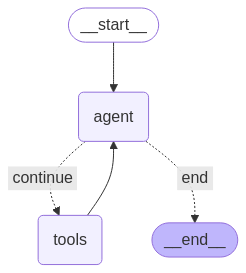

In [10]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
query = f'''the following thought part is the following \n\n{response_of_thought}'''

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", query)]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

the following thought part is the following 

"next_thought": "The experiment requires a solenoid, DC power supply, ammeter/multimeter, Gauss meter or Hall effect probe, rheostat, wires, and stands. Procedure: (1) Set up the solenoid with the magnetic sensor centered inside. (2) Connect to power supply via rheostat for variable current. (3) Measure B at increasing currents while recording I each time. (4) Plot B vs I to verify proportionality. This setup allows verification of B ∝ I as per theory."
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_results_json (96e42d4e-89a7-4ed3-9e32-55e29e16efc6)
 Call ID: 96e42d4e-89a7-4ed3-9e32-55e29e16efc6
  Args:
    query: measuring magnetic field in solenoid experiment
Task ID: 80495d60-1dfb-4d2b-b336-dc54b9bda634
Task ID: 202100fc-4114-4635-a8f3-c3a36ede9d6f
Task ID: 19d75427-7fc8-45d3-885d-27d4936b4436
Task